# Introducing space occupation 

We focus on the space occupation of basketball court by players. We'd like to know how we can quantify the occupation and how we can visualize this occupation of the court.

## Voronoi cutting
----

First, we can use Voronoi diagram to partitionate the court into cells which belong to a unique player.

### Voronoi diagram

In [3]:
from data_extracter import json_extracter
import numpy as np
import matplotlib.pyplot as plt
import math as m

data,events=json_extracter('data/game1.json')

We compute a function that plot voroni diagram of a moment of a play

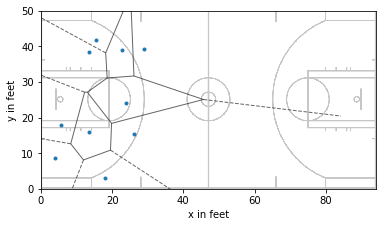

In [37]:
from scipy.spatial import Voronoi, voronoi_plot_2d

def voronoi(event_id,mom_id):
    event=events[event_id]
    moment=event['moments'][mom_id][5] # we only take the five index of moment info because it contains players' and ball's position
    points = np.array([[player[2],player[3]] for player in moment[1:]])
    vor = Voronoi(points)
    fig = voronoi_plot_2d(vor, show_vertices=False, line_colors='black',line_width=1, line_alpha=0.6, point_size=0)
    plt.xlim(0,94) #force the plt.show to adapt the size
    plt.ylim(0,50)
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')

voronoi(0,25)
field = plt.imread("Images/fullcourt.png")
plt.imshow(field, extent=[0,94,0,50])
plt.show()

Now, we want to add ball's position, player's velocity vector and to distinguish defenders and attackers

In [25]:
def players_ball_speed_position(moment1,moment2):
    team1,team2,ball =[],[],[]
    
    dt=0.04
    mom_infos={}
    mom_infos['ball']={}
    mom_infos['team1']={}
    mom_infos['team2']={}
    for i in range(11) :
        if i==0:
            mom_infos['ball']['xy']=np.array(moment1[i][2:4])
            mom_infos['ball']['z']=moment1[i][4]
            mom_infos['ball']['v']=np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])
        if 6<=i<=11:
            mom_infos['team2'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
        if 1<=i<=5:
            mom_infos['team1'][str(moment1[i][1])]={'xy':np.array(moment1[i][2:4]),'v':np.array([(moment2[i][2]-moment1[i][2])/dt,(moment2[i][3]-moment1[i][3])/dt])}
    return(mom_infos)

In [28]:
def print_court_teams_occupation(event_id,mom_id,voronoi_cut=False):
    "This function return a visualization of the court for the moment mom_id of the event event_id. If voronoi=True, voronoi cutting is plotted."
    if voronoi_cut:
        voronoi(event_id,mom_id)
    event=events[event_id]
    moment=event['moments'][mom_id][5]
    moment1=moment
    moment2=event['moments'][mom_id+1][5]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=players_ball_speed_position(moment1,moment2)
    
    for player in mom_infos['team2'].keys():
        plt.plot(mom_infos['team2'][player]['xy'][0],mom_infos['team2'][player]['xy'][1],'bo',markersize=12,alpha=0.6)
        plt.arrow(mom_infos['team2'][player]['xy'][0],mom_infos['team2'][player]['xy'][1],mom_infos['team2'][player]['v'][0],mom_infos['team2'][player]['v'][1],shape='full',lw=1.5,head_width=1)
    
    for player in mom_infos['team1'].keys():
        plt.plot(mom_infos['team1'][player]['xy'][0],mom_infos['team1'][player]['xy'][1],'ro',markersize=12,alpha=0.6)
        plt.arrow(mom_infos['team1'][player]['xy'][0],mom_infos['team1'][player]['xy'][1],mom_infos['team1'][player]['v'][0],mom_infos['team1'][player]['v'][1],shape='full',lw=1.5,head_width=1)
    
    plt.plot(mom_infos['ball']['xy'][0],mom_infos['ball']['xy'][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')

    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    plt.show()

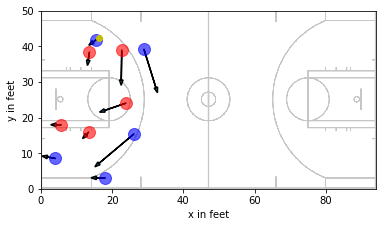

In [29]:
print_court_teams_occupation(0,25,voronoi_cut=False)

### Add a valuation to voronoi diagram

The aim is to add visual tool to make highlight the fact a player doesn't occupy his cell uniformly : the closest of a point he is, the more he control the space. To do so, we cut the court into cells and we attribute a value to each cell by making the difference between the distance of the closest player to this cell and the distance of the closest opponent of this player.

In [8]:
def distance(a,b):      #a = (x,y) departure point ; b = (i,j) arrival point
    return m.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)

In [32]:
def print_court_teams_occupation(event_id,mom_id,voronoi_cut=False,value=False,n=50,p=94):
    "This function return a visualization of the court for the moment mom_id of the event event_id. If voronoi_cut=True, voronoi cutting is plotted. Then, if value=True, a heat-map giving a value to space occupation is drawn."
    if voronoi_cut:
        voronoi(event_id,mom_id)
    event=events[event_id]
    moment=event['moments'][mom_id][5]
    moment1=moment
    moment2=event['moments'][mom_id+1][5]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=players_ball_speed_position(moment1,moment2)
    
    for player in mom_infos['team2'].keys():
        plt.plot(mom_infos['team2'][player]['xy'][0],mom_infos['team2'][player]['xy'][1],'bo',markersize=12,alpha=0.6)
        plt.arrow(mom_infos['team2'][player]['xy'][0],mom_infos['team2'][player]['xy'][1],mom_infos['team2'][player]['v'][0],mom_infos['team2'][player]['v'][1],shape='full',lw=1.5,head_width=1)
    
    for player in mom_infos['team1'].keys():
        plt.plot(mom_infos['team1'][player]['xy'][0],mom_infos['team1'][player]['xy'][1],'ro',markersize=12,alpha=0.6)
        plt.arrow(mom_infos['team1'][player]['xy'][0],mom_infos['team1'][player]['xy'][1],mom_infos['team1'][player]['v'][0],mom_infos['team1'][player]['v'][1],shape='full',lw=1.5,head_width=1)
    
    if value:
        court=np.zeros((n,p))
        for i in range(n):
            for j in range(p):
                b=np.array([j,i]) # point d'arrivée
            
                dmin_1=np.inf
                for player in mom_infos['team1'].keys():
                    a=mom_infos['team1'][player]['xy']
                    d=distance(a,b)
                    if d<dmin_1:
                        dmin_1=d
                    
                dmin_2=np.inf
                for player in mom_infos['team2'].keys():
                    a=mom_infos['team2'][player]['xy']
                    d=distance(a,b)
                    if d<dmin_2:
                        dmin_2=d
                court[i,j]=dmin_1-dmin_2
        im=plt.imshow(court,origin='lower', cmap='RdBu')
        #plt.colorbar(orientation='vertical')
        
    plt.plot(mom_infos['ball']['xy'][0],mom_infos['ball']['xy'][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')
    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    plt.show()

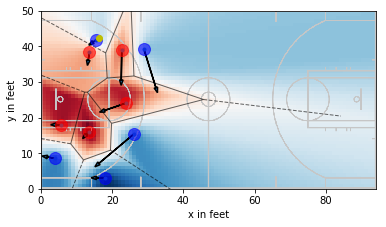

In [34]:
print_court_teams_occupation(0,25,voronoi_cut=True,value=True)

### Looking at another way of valuing

Our way of valuing only take into account the distance between closest player of each team and the point considered. Yet, players are moving and if they are moving to one direction in particular, they cannot control the are in the opposite of this region even they are closed to this opposite region. Therefore, we try to cut the court taking into account players'inertia. 

To do so, we only change our way to calculate the value : for each cell, we don't calculate a distance but the time required to one player to join this point. This time is calculated with a model in which players use a constant force to join a point. Let's look at the notebook __2 Modelling players'trajectories__ to have more information.

In [11]:
def time_to_point(a,b,v,F=10*3.281):   
    "time to go from a to b with initial speed v, F is the force parameter in feet/s-2"
    x0,y0=a
    xf,yf=b
    X=x0-xf
    Y=y0-yf
    k4=1
    k3=0
    k2=4*(v[0]**2+v[1]**2)/F**2
    k1=8*(v[0]*X+v[1]*Y)/F**2
    k0=4*(X**2+Y**2)/F**2
    times=np.roots([k4,k3,-k2,-k1,-k0])
    for i in range(4):                      # Selection of the root real and positive
        if times[i].imag==0:
            if times[i].real>0:
                return times[i].real
    print('error')

In [35]:
def print_court_teams_occupation_inertia(event_id,mom_id,voronoi_cut=False,n=50,p=94):
    "This function return a visualization of the court for the moment mom_id of the event event_id. If voronoi_cut=True, voronoi cutting is plotted. Then, if value=True, a heat-map giving a value to space occupation is drawn."
    if voronoi_cut:
        voronoi(event_id,mom_id)
    event=events[event_id]
    moment=event['moments'][mom_id][5]
    moment1=moment
    moment2=event['moments'][mom_id+1][5]
    
    # separation of ball, team1 and team2 and calculation of the speed
    mom_infos=players_ball_speed_position(moment1,moment2)
    
    for player in mom_infos['team2'].keys():
        plt.plot(mom_infos['team2'][player]['xy'][0],mom_infos['team2'][player]['xy'][1],'bo',markersize=12,alpha=0.6)
        plt.arrow(mom_infos['team2'][player]['xy'][0],mom_infos['team2'][player]['xy'][1],mom_infos['team2'][player]['v'][0],mom_infos['team2'][player]['v'][1],shape='full',lw=1.5,head_width=1)
    
    for player in mom_infos['team1'].keys():
        plt.plot(mom_infos['team1'][player]['xy'][0],mom_infos['team1'][player]['xy'][1],'ro',markersize=12,alpha=0.6)
        plt.arrow(mom_infos['team1'][player]['xy'][0],mom_infos['team1'][player]['xy'][1],mom_infos['team1'][player]['v'][0],mom_infos['team1'][player]['v'][1],shape='full',lw=1.5,head_width=1)
    
    court=np.zeros((n,p))
    for i in range(n):
        for j in range(p):
            b=np.array([j,i]) # point d'arrivée
        
            tmin_1=np.inf
            for player in mom_infos['team1'].keys():
                a=mom_infos['team1'][player]['xy']
                v=mom_infos['team1'][player]['v']
                t=time_to_point(a,b,v)
                if t<tmin_1:
                    tmin_1=t
                    
            tmin_2=np.inf
            for player in mom_infos['team2'].keys():
                a=mom_infos['team2'][player]['xy']
                v=mom_infos['team2'][player]['v']
                t=time_to_point(a,b,v)
                if t<tmin_2:
                    tmin_2=t
            
            court[i,j]=tmin_1-tmin_2
    im=plt.imshow(court,origin='lower', cmap='RdBu')
    #plt.colorbar(orientation='vertical')
        
    plt.plot(mom_infos['ball']['xy'][0],mom_infos['ball']['xy'][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')
    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    plt.show()

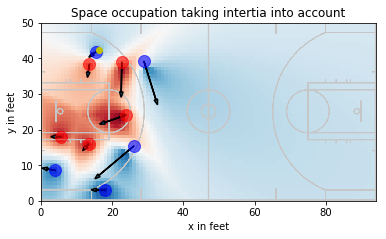

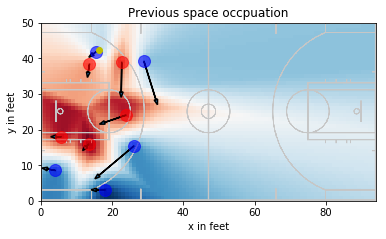

In [36]:
plt.figure(1)
plt.title('Space occupation taking intertia into account')
print_court_teams_occupation_inertia(0,25)
plt.figure(2)
plt.title('Previous space occpuation')
print_court_teams_occupation(0,25,voronoi_cut=False,value=True)

### Free spaces 
Before, we were looking at the relative occupation between team1 and team2. Another thing that can ben intested is : when looking at the offensive team one may wonder which space is not occupy by the opponent team. In fact it means we want to study the free spaces of the court left by the opposite team.

In [14]:
import matplotlib.tri as tri
def print_court_free_space(event_id,mom_id,team,n=50,p=94):
    event=events[event_id]
    moment=event['moments'][mom_id][5]
    moment1=moment
    moment2=event['moments'][mom_id+1][5]
    
    # separation of ball, team1 and team2 and calculation of the speed
    playersTeam1,playersTeam2,ball=players_ball_speed_position(event,moment1,moment2)
        
    for player in playersTeam2:
        plt.plot(player[0][0],player[0][1],'bo',markersize=7,alpha=0.6)
        plt.arrow(player[0][0],player[0][1],player[1][0],player[1][1],shape='full',lw=1.5,head_width=1)
    
    for player in playersTeam1:
        plt.plot(player[0][0],player[0][1],'ro',markersize=7,alpha=0.6)
        plt.arrow(player[0][0],player[0][1],player[1][0],player[1][1],shape='full',lw=1.5,head_width=1)
    
    court=np.zeros((n,p))
    for i in range(n):
        for j in range(p):
            b=np.array([j,i]) # point d'arrivée
            db=distance(ball[0],b)
            if team==1:
                a=playersTeam1[0][0]
                dmin=distance(a,b)
                for player in playersTeam1[1:]:
                    a=player[0]
                    d=distance(a,b)
                    if d<dmin:
                         dmin=d
            else :   
                a=playersTeam2[0][0]
                dmin=distance(a,b)
                for player in playersTeam2[1:] :
                    a=player[0]
                    d=distance(a,b)
                    if d<dmin:
                        dmin=d
            court[i,j]=dmin
    im=plt.imshow(court,origin='lower',cmap = 'YlGn',interpolation = 'sinc')
    plt.colorbar(orientation='vertical')
    
    plt.plot(ball[0][0],ball[0][1],'yo')
    plt.xlabel('x in feet')
    plt.ylabel('y in feet')
    field = plt.imread("Images/fullcourt.png")
    plt.imshow(field, extent=[0,94,0,50])
    plt.show()

In [15]:
print_court_free_space(0,25,1,n=50,p=47)

TypeError: players_ball_speed_position() takes 2 positional arguments but 3 were given

## Video
----